In [3]:
import json
import random
from collections import Counter
from pathlib import Path
from typing import Optional, Dict

import matplotlib.pyplot as plt
import numpy as np
import pysolr
from pydantic import BaseModel
from tqdm import tqdm

from data_loading import load_search_terms
from models import SearchTerm

In [4]:
class Match(BaseModel):
    mention: SearchTerm
    match: Optional[Dict] = None
    matched_string: Optional[str] = None


solr_special_chars = '+ - && || ! ( ) { } [ ] ^ " ~ * ? : /'.split()

In [5]:
solr = pysolr.Solr('http://localhost:8983/solr/wumls-single-doc-valued',
                   always_commit=False)
# solr = pysolr.Solr('http://localhost:8983/solr/wumls-multi-valued', always_commit=False)
solr.ping()

'{\n  "responseHeader":{\n    "zkConnected":null,\n    "status":0,\n    "QTime":10,\n    "params":{\n      "q":"{!lucene}*:*",\n      "distrib":"false",\n      "df":"_text_",\n      "rows":"10",\n      "echoParams":"all",\n      "rid":"localhost-1"}},\n  "status":"OK"}\n'

In [6]:
def show_search_score_proportion(matches):
    nums_matched = []
    scores = [match.match['score'] for match in matches]
    x = np.linspace(min(scores), max(scores), 10)
    for threshold in x:
        num_matched = len([match for match in matches if match.match['score'] > threshold])
        nums_matched.append(num_matched / len(matches))

    fig, ax = plt.subplots()
    ax.plot(x, nums_matched)
    ax.set_xlabel("score threshold")
    ax.set_ylabel("% matched")
    ax.grid()
    plt.show()


In [7]:
distances = {True: 1, False: 2}


def add_tilde_to_search_terms(term):
    return " AND ".join([s + f"~{distances[len(s) < 4]}" for s in term.split(" ")])

In [8]:
search_term = "kolik"
# results = solr.search(q=f"index_term_str:{add_tilde_to_search_terms(search_term)}", fl="*", rows=10)
results = solr.search(q=f"index_term:{search_term}", fl="*,score", rows=2)
for res in results:
    print(res)

{'cui': ['C0232488'], 'source': ['MDRGER'], 'language': ['GER'], 'name': ['Kolik, Kolik, KOLIK ABDOMINAL, Kolik abdominal, abdominale Kolik'], 'index_term': ['kolik, kolik abdominal, abdominal kolik, kolik, kolik abdominal, abdominale kolik'], 'id': 'c6e9cabb-6279-406e-b740-b7ac0c7d9cf3', '_version_': 1760196500712849435, 'score': 8.273389}
{'cui': ['C0266836'], 'source': ['MDRGER'], 'language': ['GER'], 'name': ['infantile Kolik, infantile Kolik, infantile Kolik, Kolik beim Saeugling, Dreimonatskolik, Kolik infantil'], 'index_term': ['infantil kolik, kolik beim saeugling, kolik infantil, dreimonatskolik, kolik beim saeugling, infantile kolik, kolik infantil, dreimonatskolik'], 'id': '01fb3f21-9b6f-4125-a75e-e42d51ab0794', '_version_': 1760196500842872833, 'score': 7.7050924}


In [9]:
search_terms = load_search_terms()

In [10]:
search_terms.terms[0]

SearchTerm(annotation=Annotation(tech_term=None, lay_term='Blähungen', type=<TermType.LAY: 'LAY'>, span_start=86, span_end=95, synonyms=['Flatulenzen'], id=6992), stems={'blahung', 'wind', 'luftansammlung im darm', 'blah', 'blaehung', 'meteorismu', 'flatulenz', 'meteorisnu'})

In [11]:
def filter_results_by_common_cuis(results):
    cuis = [d['cui'][0] for d in results]
    counter = Counter(cuis)
    most_common_match_cui = counter.most_common()[0][0]
    most_common_match = next(d for d in results if d['cui'][0] == most_common_match_cui)
    return most_common_match

# matched, not_matched = [], []
# for term in tqdm(search_terms.terms):
#     try:
#         res = solr.search(q=f"index_term:{' '.join(term.stems)}", fl="*,score", rows=1)
#     except pysolr.SolrError:
#         continue
#     if not res:
#         not_matched.append(Match(mention=term))
#     else:
#         matched.append(Match(mention=term, match=list(res)[0]))   
        
matched, not_matched = [], []
for term in tqdm(search_terms.terms):
    # simple, not weighted majority vote for cui
    results = []
    for stem in term.stems:
        # for char in solr_special_chars:
        #     stem = stem.replace(char, '\\' + char)
        try:
            res = solr.search(q=f"index_term:{stem}", fl="*,score", rows=1)
        except pysolr.SolrError:
            continue
        if not res:
            # print('no res found')
            continue
        # print('found res')
        top_result = list(res)[0]
        # if top_result['score'] < .5:
        #     continue
        top_result['stem'] = stem
        results.append(top_result)
    if results:
        most_common_match = filter_results_by_common_cuis(results=results)
        matched.append(Match(mention=term, match=most_common_match, matched_string=most_common_match['stem']))
    else:
        not_matched.append(Match(mention=term))

100%|██████████| 7390/7390 [03:23<00:00, 36.39it/s]


In [ ]:
path = Path('matched_doc_style.json')
if path.exists():
    print("path exists")
else:
    with open(path, 'w') as fp:
        json.dump([match.json() for match in matched], fp)

In [ ]:
path = Path('not_matched_doc_style.json')
if path.exists():
    print("path exists")
else:
    with open(path, 'w') as fp:
        json.dump([match.json() for match in not_matched], fp)

In [12]:
print(f"{len(matched)=}")
print(f"{len(not_matched)=}")


len(matched)=7311
len(not_matched)=79


In [13]:
# path = Path('matched_doc_style.json')
# with open(path, 'r') as fp:
#     matched_loaded = json.load(fp)
# matched_loaded = [Match.parse_obj(json.loads(match)) for match in matched_loaded]
matched_loaded = matched

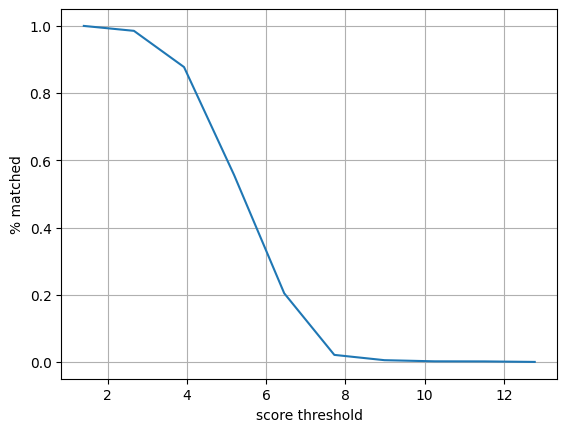

In [14]:
show_search_score_proportion(matched_loaded)

In [15]:
def print_n_matches(matches, n=10):
    for matched_item in random.sample(matches, n):
        annotation = matched_item.mention.annotation
        synonyms_from_tlc = matched_item.mention.stems
        original_mention = annotation.get_mention()
        matched_string = matched_item.matched_string if matched_item.matched_string else synonyms_from_tlc
        print(matched_string, " matched with ", matched_item.match['index_term'],
              f"(score = {matched_item.match['score']})")
        print()


print_n_matches(matched_loaded)

spiegelung  matched with  ['endoskopie, endoskopie nnb, spiegelung, endoskopie, endoskopie nnb, spiegelung'] (score = 7.453394)

sein orga sind all betroff  matched with  ['traurig sein, traurig sein'] (score = 6.6380305)

karzinom  matched with  ['epidermoid karzinom, plattenepithelkarzinom, karzinom squamo, karzinom, flachzellig, karzinom, plattenepithel-, karzinom epidermoid, karzinom, epidermoid-, karzinom, plattenepithelial, karzinom squamoes, plattenepithelkarzinom, epidermoides karzinom, karzinom, plattenepithel-, karzinom epidermoid, karzinom, epidermoid-, karzinom, flachzelliges, karzinom, plattenepitheliales'] (score = 4.631187)

druck auf dem brustkorb  matched with  ['druck, druck'] (score = 5.6850624)

magenschleimhautentzuendung  matched with  ['magenentzundung, gastriti nnb, magenentzuendung, gastriti, gastritis, nich naeh bezeich, magenschleimhautentzundung, entzuendung, mag, magenschleimhautentzuendung, magenkatarrh, gastritis, magenentzuendung, magenentzündung, gastri

In [18]:
threshold = 5  
cutoff_matches = [match for match in matched_loaded if match.match['score'] > threshold]
below_cutoff = [match for match in matched_loaded if match.match['score'] <= threshold]
print(len(cutoff_matches), '/', len(matched_loaded))
print_n_matches(cutoff_matches)

4750 / 7311
maschi  matched with  ['lebenserhal maschi, lebenserhaltende maschine'] (score = 5.600058)

brenn beim pinkel  matched with  ['brenn, fuehl brenn, brenn nnb, gefuehl brennend, brennen nnb, brennen'] (score = 5.3378315)

atopisch ekzem  matched with  ['atopie, atopisch, atopie, atopisch'] (score = 6.5936756)

appendix vermiformi  matched with  ['wurmfortsatz, appendix, wurmfortsatz, appendix'] (score = 6.5936756)

lumbago  matched with  ['aku lumbago, akuter lumbago'] (score = 7.617442)

pneumonie  matched with  ['pneumonie eosinophil, eosinophil pneumonie, pneumonie, eosinophil, pneumonie eosinophile, eosinophile pneumonie, pneumonie, eosinophile'] (score = 5.3194695)

vertigo  matched with  ['vertigo objektiv, vertigo objektiv'] (score = 6.910166)

suppositorium  matched with  ['zapfch, zapfch (gaumen), suppositorium, staphyl, gaumenzapfch, uvula, gaumenzäpfchen, staphyle, zäpfchen (gaumen), suppositorium, zäpfchen, uvula'] (score = 6.3367305)

bewegungsschmerz  matched wi

In [19]:
print_n_matches(below_cutoff)

psychisch verfassung dara schuld  matched with  ['unterbringung psychisch krank, unterbringung psychisch kranker'] (score = 4.4948196)

vomitu  matched with  ['vomitio, erbrech, vomitu, erbrach, erbrech nnb, emesi, vomitio, vomitus, erbrach, erbrechen nnb, emesis, erbrechen'] (score = 4.417637)

ursach  matched with  ['multifaktoriell ursach, multifaktorielle ursache'] (score = 3.8189948)

karzinom  matched with  ['epidermoid karzinom, plattenepithelkarzinom, karzinom squamo, karzinom, flachzellig, karzinom, plattenepithel-, karzinom epidermoid, karzinom, epidermoid-, karzinom, plattenepithelial, karzinom squamoes, plattenepithelkarzinom, epidermoides karzinom, karzinom, plattenepithel-, karzinom epidermoid, karzinom, epidermoid-, karzinom, flachzelliges, karzinom, plattenepitheliales'] (score = 4.631187)

niernstei  matched with  ['nierenkonkrement, nierenstei nnb, niernstei, nierenstei, nephrolith, calculi renal, nierenstein, nierenkonkremente, nierenkonkrement, calculi renales, nier